<a href="https://colab.research.google.com/github/olley102/CommunityDetectionURSS/blob/main/optical_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optical Flow

Based on (Horn, B., Schunk, B., *Determining Optical Flow* 1981).

## 1. Estimating partial derivatives

In [2]:
import numpy as np

In [ ]:
def image_seq_partial(arr):
  # Pad the lower-right boundary of each frame, and pad the back frame.
  padded = np.pad(arr, ((0, 1), (0, 1), (0, 1)), mode='edge')

  # Shift the entire array to get 8 neighbouring measurements.
  shift000 = arr
  shift001 = padded[:, :, 1:]
  shift010 = padded[:, 1:, :]
  shift011 = padded[:, 1:, 1:]
  shift100 = padded[1:, :, :]
  shift101 = padded[1:, :, 1:]
  shift110 = padded[1:, 1:, :]
  shift111 = padded[1:, 1:, 1:]

  # Approximate derivatives.
  partial_x = 0.25 * (shift010 - shift000 + shift110 - shift100 + shift011 - shift001 + shift111 - shift101)
  partial_y = 0.25 * (shift100 - shift000 + shift110 - shift010 + shift101 - shift001 + shift111 - shift011)
  partial_t = 0.25 * (shift001 - shift000 + shift101 - shift100 + shift011 - shift010 + shift111 - shift110)

  # Concatenate and return at positions available in arr.
  return np.stack((
      partial_x[:-1, :-1, :-1],
      partial_y[:-1, :-1, :-1],
      partial_t[:-1, :-1, :-1]
  ), axis=-1)

## 2. Estimating the Laplacian of the flow velocities

In [3]:
from scipy.signal import convolve2d

In [68]:
def image_seq_laplacian(arr):
  # Pad all spatial boundaries.
  if len(arr.shape) == 2:
    arr_new = np.expand_dims(arr, axis=-1)
  elif len(arr.shape) == 3:
    arr_new = arr
  else:
    raise ValueError('Wrong input dimension. Must be 2 or 3.')
  padded = np.pad(arr_new, ((1, 1), (1, 1), (0, 0)), mode='edge')

  # Convolution kernel.
  kernel = np.array([
      [0.25, 0.5, 0.25],
      [0.5, -3.0, 0.5],
      [0.25, 0.5, 0.25]
  ])

  # Convolve each frame of padded with kernel and discard boundary.
  lap = np.zeros_like(arr_new, dtype='float')
  for f in range(arr_new.shape[-1]):
    lap[..., f] += convolve2d(padded[..., f], kernel, mode='valid')
  
  return lap

In [69]:
u_test = np.array([
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [0, 0, 0, -1, -1, -1],
    [0, 0, 0, -1, -1, -1],
    [0, 0, 0, -1, -1, -1]
])

In [70]:
lap_u = image_seq_laplacian(u_test)

In [73]:
v_test = np.array([
    [-1, -1, -1, 0, 0, 0],
    [-1, -1, -1, 0, 0, 0],
    [-1, -1, -1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1],
    [0, 0, 0, 1, 1, 1]
])

In [74]:
lap_v = image_seq_laplacian(v_test)

In [75]:
lap_v.shape

(6, 6, 1)

In [76]:
import matplotlib.pyplot as plt

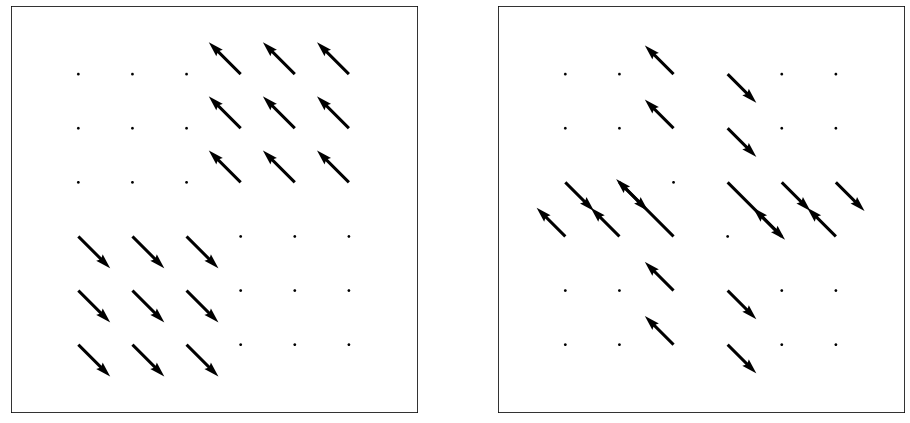

In [77]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(121)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_aspect('equal')
plt.quiver(u_test, v_test)
plt.margins(0.25, 0.25)

ax2 = fig.add_subplot(122)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax2.set_aspect('equal')
plt.quiver(lap_u[..., 0], lap_v[..., 0])
plt.margins(0.25, 0.25)
plt.show()

## 3. Iterative solution